<a href="https://colab.research.google.com/github/AritraStark/E2E_GSOC_2022/blob/main/E2E_eval_task_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Common Task 1. Electron/photon classification**

Datasets:

https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc (photons)

https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA (electrons)

Description: 32x32 matrices (two channels - hit energy and time) for two classes of particles electrons and photons impinging on a calorimeter
Please use a deep learning method of your choice to achieve the highest possible
classification on this dataset (we ask that you do it both in Keras/Tensorflow and in PyTorch). Please provide a Jupyter notebook that shows your solution. The model yousubmit should have a ROC AUC score of at least 0.80.

Downloading the datasets from the links provided: 

In [ ]:
!wget https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc/download -O photons.hdf5
!wget https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA/download -O electrons.hdf5

--2022-04-04 15:41:23--  https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.170.17, 188.184.97.72, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.170.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119703858 (114M) [application/octet-stream]
Saving to: ‘photons.hdf5’

photons.hdf5        100%[===================>] 114.16M   121MB/s    in 0.9s    

Last-modified header invalid -- time-stamp ignored.
2022-04-04 15:41:26 (121 MB/s) - ‘photons.hdf5’ saved [119703858/119703858]

--2022-04-04 15:41:26--  https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.170.17, 188.184.97.72, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.170.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128927319 (123M) [application/octet-stream]
Saving to: ‘electrons.hdf5’

el

Setting up the imports:

In [ ]:
import numpy as np
import tensorflow as tf
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc

print(tf.__version__)

2.8.0


Get the data from the downloaded HDF5 files and combine the loaded datasets:

In [ ]:
X_electron = np.array(h5py.File("electrons.hdf5",'r').get(name="X")[()])
y_electron = np.array(h5py.File("electrons.hdf5",'r').get(name="y")[()])
X_photon = np.array(h5py.File("photons.hdf5",'r').get(name="X")[()])
y_photon = np.array(h5py.File("photons.hdf5",'r').get(name="y")[()])

X_particles = np.concatenate((X_electron,X_photon),axis=0)
y_particles = np.concatenate((y_electron,y_photon),axis=0)
print(X_particles.shape,y_particles.shape)

del X_electron
del X_photon
del y_electron
del y_photon

index = np.random.permutation(len(y_particles))
X_particles, y_particles = X_particles[index][:,:,:,0].reshape((-1,32*32)), y_particles[index]

(498000, 32, 32, 2) (498000,)


Splitting the data into training and testing sets ( I have split it in 80-20 as per instructions): 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X_particles, y_particles, random_state=48, test_size=0.2 )

del X_particles
del y_particles

#X_train, X_test, y_train, y_test = train_test_split( X_train_m, y_train_m, random_state=48, test_size=0.2 )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((398400, 1024), (99600, 1024), (398400,), (99600,))

Defining the VGG model:

In [ ]:
model = tf.keras.applications.VGG16(
          include_top=True, 
          weights=None,
          input_shape=(32,32,1),
          classes=1,
          classifier_activation='sigmoid'
)

Defining a CNN model:

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(512, activation = 'relu', input_shape= (32*32,)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation = 'relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation = 'relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation = 'relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation = 'sigmoid')
])

Get model summary:

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 512)               524800    
                                                                 
 dropout_23 (Dropout)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 512)               262656    
                                                                 
 dropout_24 (Dropout)        (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 256)               131328    
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_29 (Dense)            (None, 256)              

Defining callbacks:

In [ ]:
filepath="classifier_weights2-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint1 = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

Compiling the model and fitting it with testing data:

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(X_train,  y_train, 
                    validation_split=0.2, 
                    epochs=20, 
                    callbacks=callbacks_list
)

Epoch 1/20
9952/9960 [============================>.] - ETA: 0s - loss: 0.5750 - accuracy: 0.7133
Epoch 1: val_accuracy did not improve from 0.72594
9960/9960 [==============================] - 51s 5ms/step - loss: 0.5750 - accuracy: 0.7133 - val_loss: 0.5603 - val_accuracy: 0.7218
Epoch 2/20
9953/9960 [============================>.] - ETA: 0s - loss: 0.5732 - accuracy: 0.7149
Epoch 2: val_accuracy did not improve from 0.72594
9960/9960 [==============================] - 50s 5ms/step - loss: 0.5732 - accuracy: 0.7149 - val_loss: 0.5653 - val_accuracy: 0.7192
Epoch 3/20
9952/9960 [============================>.] - ETA: 0s - loss: 0.5731 - accuracy: 0.7149
Epoch 3: val_accuracy did not improve from 0.72594
9960/9960 [==============================] - 50s 5ms/step - loss: 0.5730 - accuracy: 0.7149 - val_loss: 0.5565 - val_accuracy: 0.7244
Epoch 4/20
9950/9960 [============================>.] - ETA: 0s - loss: 0.5734 - accuracy: 0.7147
Epoch 4: val_accuracy did not improve from 0.72594
99

Plotting the results:

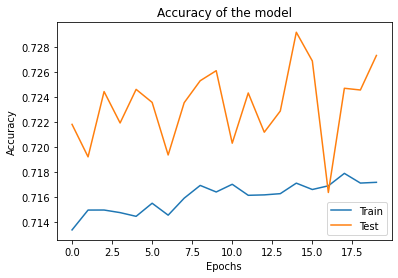

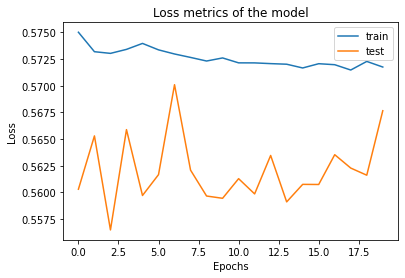

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss metrics of the model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Check the performance of the model on predictions:

In [ ]:
best_epoch=np.argmax(history.history['val_accuracy'])
best_acc=np.max(history.history['val_accuracy'])
model.load_weights('/content/classifier_weights2-improvement-15-0.73.hdf5')
predictions = model.predict(X_test)
print("ROC AUC:")
roc_auc_score(y_test, predictions)

ROC AUC:


0.7853177911179511

Classification Report and ROC AUC score:

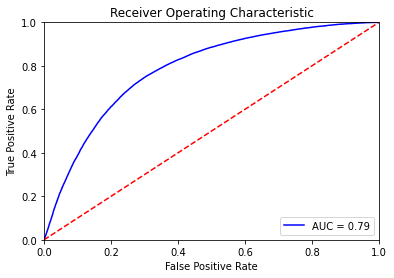

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The model that I have used here is a linear Neural Network and achieved almost 0.80 ROC AUC score. Due to the high volume of the dataset using a pre-trained model like VGG or ResNet has been difficult due to the limitations of the online resources provided in colab but could theoretically achieve higher ROC AUC score.

**References :**


1.   [Examining Electron and Photon Classification Using Convolutional Neural Networks
Jonah Warner, Research Assistant
Department of Physics, Carnegie Mellon University, Pittsburgh 15213](https://www.cmu.edu/ai-physics-institute/outreach/surp/images/2021/jonah-warner-poster.pdf)
2.   [End-to-End Event Classification of High-Energy
Physics Data
M Andrews
, M Paulini
, S Gleyzer
, B Poczos](https://indico.cern.ch/event/567550/papers/2629451/files/7515-end-end-event_v4.pdf)
3.   [Calorimetry with Deep Learning: Particle
Classification, Energy Regression, and Simulation for
High-Energy Physics
Federico Carminati, Gulrukh Khattak, Maurizio Pierini
CERN](https://dl4physicalsciences.github.io/files/nips_dlps_2017_15.pdf)
4.  [Electron/Photon Ambiguity Resolution Using Neural
networks For ATLAS Experiment
Nutthawara Buatthaisong, Khon Kaen University, Thailand
](https://www.desy.de/f/students/2019/reports/nutthawara.buatthaisong.pdf)
